# Imports

In [107]:
import sys
import os
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score   
import time

from typing import List, Dict, Union, Optional, Tuple
import torch

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Retrieving the data

In [108]:
CharacterTrajectoriesDataPath = "/cim/mmohamed/Courses/ECSE552/ECSE552-project/data/processed/CharacterTrajectories/classification"
x_train = torch.load(CharacterTrajectoriesDataPath + "/X_train.pt").float().to(device)
y_train = torch.tensor(torch.load(CharacterTrajectoriesDataPath + "/y_train.pt")).long().to(device)
x_test = torch.load(CharacterTrajectoriesDataPath + "/X_test.pt").float().to(device) 
y_test = torch.tensor(torch.load(CharacterTrajectoriesDataPath + "/y_test.pt")).long().to(device)


### Visualizing the data

In [109]:
print(x_train.shape)
# print(x_train[:2])
print(y_train.shape)
# print(y_train[:5])
# print all classes in y_train
print(torch.unique(y_train))



torch.Size([2286, 182, 4])
torch.Size([2286])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], device='cuda:0')


## helper method for getting the length of the given input

In [110]:
def getLenghts(inputs):
    # inputs is a tensor of size batch * 182 * 4
    # returns a list of size batch
    lengths = []
    for i in range(inputs.shape[0]):
        for j in range(1,inputs.shape[1]+1):
            if j == inputs.shape[1] or inputs[i][j][0] == 0:
                lengths.append(j)
                break
    
        

    return torch.tensor(lengths, dtype=torch.long).cpu()
# l=getLenghts(x_train)
# print(l, len(l))

In [111]:
from torch.utils.data import Dataset, DataLoader

class CharacterTrajectoriesDataset(Dataset):
    def __init__(self, x, y, get_lengths):
        self.x = x
        self.y = y
        self.get_lengths = get_lengths

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def collate_fn(batch):
        x, y = zip(*batch)
        x = torch.stack(x).to(device)
        lengths = getLenghts(x)
        y = torch.tensor(y).to(device)
        return x, y, lengths

train_dataset = CharacterTrajectoriesDataset(x_train, y_train, getLenghts)
test_dataset = CharacterTrajectoriesDataset(x_test, y_test, getLenghts)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=CharacterTrajectoriesDataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=CharacterTrajectoriesDataset.collate_fn)


# Models

In [112]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths):
        # Pack the sequence
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # RNN
        out, _ = self.rnn(x_packed)
        # Unpack sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # Only want last time step hidden states
        out = out[range(out.shape[0]), lengths - 1, :]
        # Linear layer
        out = self.fc(out)
        return out


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths):
        # Pack the sequence
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # LSTM
        out, (hn, cn) = self.lstm(x_packed)
        # Unpack sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # Only want last time step hidden states
        out = out[range(out.shape[0]), lengths - 1, :]
        # Linear layer
        out = self.fc(out)
        return out


# Train method

In [115]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Lists to store per-epoch loss and accuracy
    train_losses = []
    eval_losses = []
    eval_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, lengths in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch, lengths)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for x_batch, y_batch, lengths in test_loader:
                outputs = model(x_batch, lengths)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)

        avg_val_loss = total_val_loss / len(test_loader)
        val_accuracy = total_correct / total_samples

        eval_losses.append(avg_val_loss)
        eval_accs.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation loss.")
            break

    return train_losses, eval_losses, eval_accs


In [117]:
def plot_learning_curves(train_losses, eval_losses, eval_accs, title='Learning Curves'):
    # Extract the data for plotting
    iterations = list(range(1, len(train_losses) + 1))

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_losses, 'r-', label='Training Loss')
    plt.plot(iterations, eval_losses, 'b-', label='Validation Loss')
    plt.xlabel('Training Iterations')
    plt.ylabel('Loss')
    plt.title(title + ' - Loss')
    plt.legend(loc='upper left')
    plt.savefig(title + '_loss.png')  # Save the plot as a PNG file
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, eval_accs, 'g-', label='Validation Accuracy')
    plt.xlabel('Training Iterations')
    plt.ylabel('Accuracy (%)')
    plt.title(title + ' - Accuracy')
    plt.legend(loc='upper left')
    plt.savefig(title + '_accuracy.png')  # Save the plot as a PNG file
    plt.show()



# Training

Epoch 1/100, Train Loss: 2.8369, Val Loss: 2.4564, Val Acc: 0.1853
Epoch 2/100, Train Loss: 2.3950, Val Loss: 2.5662, Val Acc: 0.2010
Epoch 3/100, Train Loss: 2.3402, Val Loss: 2.2903, Val Acc: 0.2325
Epoch 4/100, Train Loss: 2.2415, Val Loss: 2.1791, Val Acc: 0.2990
Epoch 5/100, Train Loss: 2.1063, Val Loss: 2.1699, Val Acc: 0.2850
Epoch 6/100, Train Loss: 2.0132, Val Loss: 1.8701, Val Acc: 0.3689
Epoch 7/100, Train Loss: 2.0129, Val Loss: 1.9182, Val Acc: 0.3776
Epoch 8/100, Train Loss: 1.9634, Val Loss: 2.0267, Val Acc: 0.3304
Epoch 9/100, Train Loss: 2.0092, Val Loss: 2.3426, Val Acc: 0.2640
Epoch 10/100, Train Loss: 1.9277, Val Loss: 1.8055, Val Acc: 0.4458
Epoch 11/100, Train Loss: 2.0312, Val Loss: 1.8402, Val Acc: 0.4126
Epoch 12/100, Train Loss: 1.8124, Val Loss: 1.8442, Val Acc: 0.3689
Epoch 13/100, Train Loss: 1.8365, Val Loss: 1.6166, Val Acc: 0.4703
Epoch 14/100, Train Loss: 1.6232, Val Loss: 1.4635, Val Acc: 0.5350
Epoch 15/100, Train Loss: 1.6848, Val Loss: 1.4563, Val A

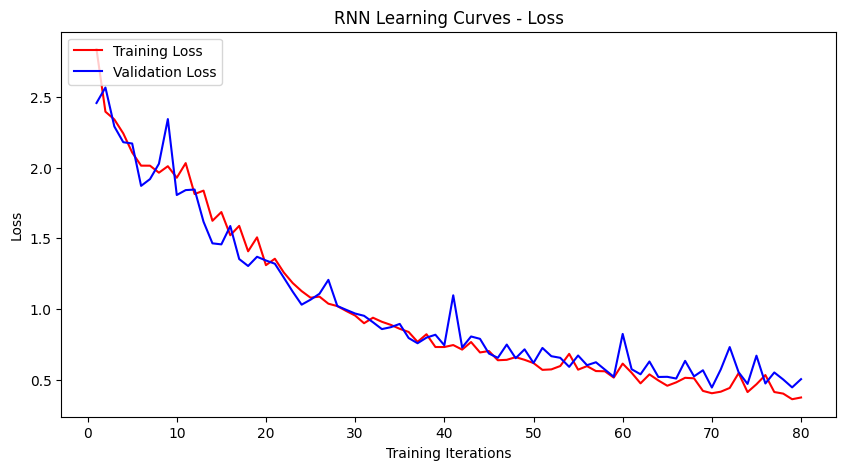

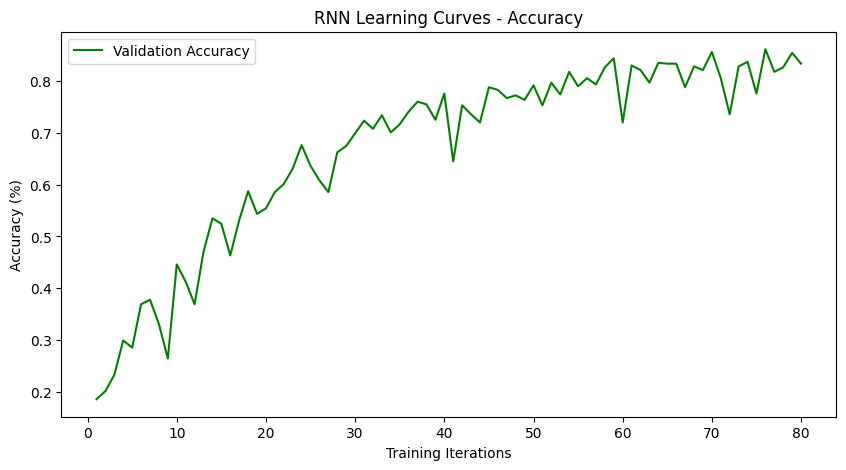

Epoch 1/100, Train Loss: 2.7284, Val Loss: 2.3608, Val Acc: 0.1993
Epoch 2/100, Train Loss: 2.2888, Val Loss: 2.1846, Val Acc: 0.2535
Epoch 3/100, Train Loss: 2.1692, Val Loss: 2.0761, Val Acc: 0.3252
Epoch 4/100, Train Loss: 2.0454, Val Loss: 2.1636, Val Acc: 0.2797
Epoch 5/100, Train Loss: 1.8482, Val Loss: 1.7620, Val Acc: 0.4371
Epoch 6/100, Train Loss: 1.4958, Val Loss: 1.1780, Val Acc: 0.6154
Epoch 7/100, Train Loss: 1.0591, Val Loss: 0.9252, Val Acc: 0.6713
Epoch 8/100, Train Loss: 0.8191, Val Loss: 0.7630, Val Acc: 0.7185
Epoch 9/100, Train Loss: 0.6871, Val Loss: 0.5707, Val Acc: 0.8007
Epoch 10/100, Train Loss: 0.6713, Val Loss: 0.7995, Val Acc: 0.7203
Epoch 11/100, Train Loss: 0.6183, Val Loss: 0.7830, Val Acc: 0.7395
Epoch 12/100, Train Loss: 0.4918, Val Loss: 0.4622, Val Acc: 0.8566
Epoch 13/100, Train Loss: 0.4097, Val Loss: 0.4063, Val Acc: 0.8671
Epoch 14/100, Train Loss: 0.3664, Val Loss: 0.3534, Val Acc: 0.8881
Epoch 15/100, Train Loss: 0.4048, Val Loss: 0.3694, Val A

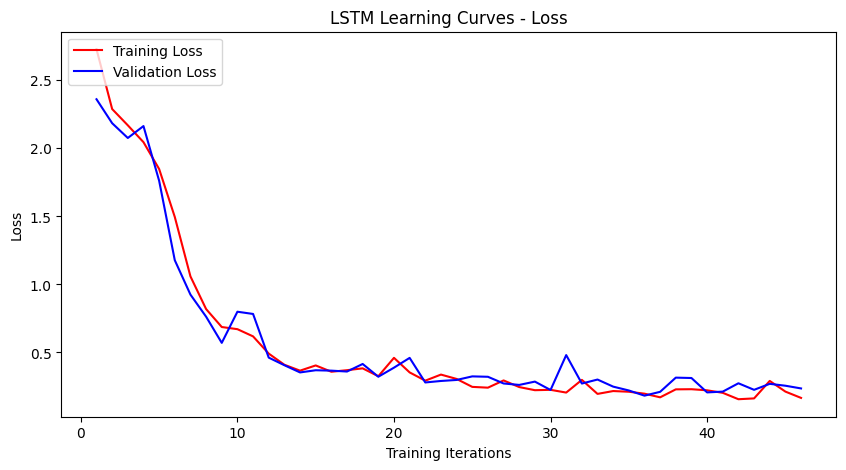

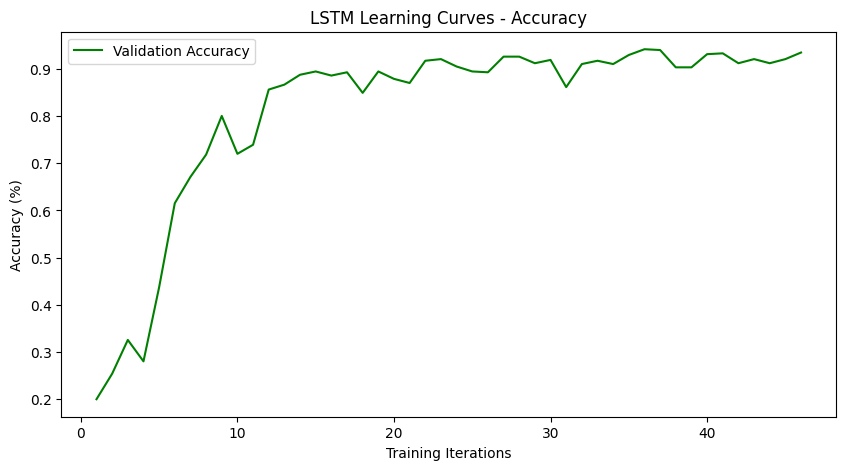

In [119]:
input_dim = 4
hidden_dim = 128  
layer_dim = 2     
output_dim = 20

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, eval_losses, eval_accs = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=10)

plot_learning_curves(train_losses, eval_losses, eval_accs, "RNN Learning Curves")

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, eval_losses, eval_accs = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=10)

plot_learning_curves(train_losses, eval_losses, eval_accs, "LSTM Learning Curves")
